 <center> <h1> SPOTIFY PLAYLIST MAKER </h1> </center>
 
Scope: This project aims to manipulate the Spotify music data with Python, having a twofold scope:

✔️ proving that the existence of an API (Application Programming Interface) is of high importance, in terms of feeding algorithms with extra fine data.

✔️ demonstrating how plain statistics (when properly applied) can encode daily actions, break them down into their fundamental elements and on top of them build valuable products.


## Tools

- Spotipy
- requests
- numpy
- pandas
- kopi :) 


## Modus Operandi
- Get my personal playlist 
- Get my friend personal playlist
- check if we have same interest of music  (using song feature not genre) 
- generate new playlist based on our interest


## Install External Library 

by default spotipy and request doesn't include in conda env so we need to install it externally from pip :)

In [98]:
# install lib
!pip install spotipy
!pip install requests

import all library that we will used

In [99]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util

from spotipy.oauth2 import SpotifyClientCredentials

I'm using spotify api https://developer.spotify.com/  

you can read docs to have this credentials 

In [100]:
# spotify credentials
spotify_client_id ="61fce9db76db43adbb90fbb6ad9c2c68"
spotify_client_secret="cd23ed14c33342dca1de5169dfb488c9"
redirect_uri='http://localhost:7777/callback'
username = '216s6qezspzqiumacigmkflri'


## Get ALL MY PLAYLIST 

In [101]:
client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
playlists = sp.user_playlists(username)
for playlist in playlists['items']:
    print('Name: {}, Playlist ID: {}, No Tracks: {}'.
          format(playlist['name'], playlist['id'], playlist['tracks']['total']))

Name: mamimumemo, Playlist ID: 6rE4pkAcCzsrKFFaqTUfG7, No Tracks: 133
Name: hilu kimu wulrd, Playlist ID: 7AFQPqLpbDYkOr9bYAbHlJ, No Tracks: 299
Name: +2 nov :), Playlist ID: 7JnQZulXjxqJcTGBjRQcId, No Tracks: 249
Name: My playlist #1, Playlist ID: 5FLDyGcuJqAedwjPbhCNeA, No Tracks: 3


# Convert json to dataframe

In [102]:
def fetch_playlists():
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [103]:
playlists = fetch_playlists()
playlists

,id,name,#tracks
0,6rE4pkAcCzsrKFFaqTUfG7,mamimumemo,133
1,7AFQPqLpbDYkOr9bYAbHlJ,hilu kimu wulrd,299
2,7JnQZulXjxqJcTGBjRQcId,+2 nov :),249
3,5FLDyGcuJqAedwjPbhCNeA,My playlist #1,3


In [104]:
def fetch_playlist_tracks(playlist_id):
    """
    Returns the tracks for the given playlist.
    """
        
    offset = 0
    tracks = []
    
    # Make the API request
    while True:
        content = sp.user_playlist_tracks(username, playlist_id, fields=None, limit=100, offset=offset, market=None)
        tracks += content['items']
        
        if content['next'] is not None:
            offset += 100
        else:
            break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
    # Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

In [105]:

# check track in kimu playlist
hilu_pid = "7AFQPqLpbDYkOr9bYAbHlJ"
joo_pid = "7JnQZulXjxqJcTGBjRQcId"
hilu_track =  fetch_playlist_tracks(hilu_pid)
hilu_track.head()


,track_id,track_name
0,2ylVfK4pVfeSV4zxieyT2B,Touch
1,5QTdOvIF2ehBMZpSIIGzIo,Honey
2,6bsg90K6hmiDiGF839rOPE,Honesty
3,1OxL1FWSEd7QmJoWLRP2NO,On My Mind (Jorja Smith X Preditah)
4,4mL59LVbKgOpEACxraGYdr,While We're Young


In [106]:
# check track in joo playlist
joo_track =  fetch_playlist_tracks(joo_pid)
joo_track.head()


,track_id,track_name
0,02HKcf9brW0TlqEHTmAgXM,Jangan Bertengkar Lagi Ya? OK? OK!
1,1SbpxkBg8DnkbTDgflkf6w,Siapkah Kau 'Tuk Jatuh Cinta Lagi
2,74OLXYsvpfmSgPCMMi898K,bitterlove
3,77SiKnkNEnRw0uoPE4wuEp,cigarettes of ours
4,6claTdKnG2FOnikFadYeno,fake optics


In [107]:
def fetch_audio_features(playlist_id):
    playlist = fetch_playlist_tracks( playlist_id)
    index = 0
    audio_features = []

    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    features_list = []
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['energy'], features['tempo'],
                              features['loudness'], features['valence'],
                              features['speechiness'], features['instrumentalness'],
                              features['liveness'], features['acousticness']])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'energy',
                                                             'tempo', 'loudness', 'valence',
                                                             'speechiness', 'instrumentalness',
                                                             'liveness', 'acousticness'])
    
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_id', inplace=True, drop=True)
        
    return df_playlist_audio_features

In [108]:
#get audio feature from spotlipy
df_hilu = fetch_audio_features(hilu_pid)
df_hilu.head()


,track_name,danceability,energy,tempo,loudness,valence,speechiness,instrumentalness,liveness,acousticness
track_id,,,,,,,,,,
2ylVfK4pVfeSV4zxieyT2B,Touch,0.731,0.662,89.927,-11.580,0.432,0.2550,0.001020,0.2200,0.568
5QTdOvIF2ehBMZpSIIGzIo,Honey,0.606,0.240,96.792,-7.102,0.526,0.0369,0.000000,0.0819,0.772
6bsg90K6hmiDiGF839rOPE,Honesty,0.660,0.139,79.975,-16.339,0.312,0.0323,0.000011,0.1050,0.964
1OxL1FWSEd7QmJoWLRP2NO,On My Mind (Jorja Smith X Preditah),0.710,0.662,130.037,-5.947,0.755,0.1750,0.000000,0.0723,0.420
4mL59LVbKgOpEACxraGYdr,While We're Young,0.649,0.791,128.023,-6.013,0.811,0.1930,0.000002,0.1080,0.104


In [109]:
# get audio feature from spotlipy
df_joo = fetch_audio_features(joo_pid)
df_joo

,track_name,danceability,energy,tempo,loudness,valence,speechiness,instrumentalness,liveness,acousticness
track_id,,,,,,,,,,
02HKcf9brW0TlqEHTmAgXM,Jangan Bertengkar Lagi Ya? OK? OK!,0.741,0.375,134.046,-8.445,0.337,0.0388,0.011600,0.0712,0.6620
1SbpxkBg8DnkbTDgflkf6w,Siapkah Kau 'Tuk Jatuh Cinta Lagi,0.689,0.252,130.024,-12.215,0.426,0.0355,0.001230,0.0993,0.9680
74OLXYsvpfmSgPCMMi898K,bitterlove,0.678,0.531,149.393,-10.920,0.574,0.0384,0.001600,0.1250,0.3930
77SiKnkNEnRw0uoPE4wuEp,cigarettes of ours,0.609,0.218,112.203,-14.225,0.386,0.0340,0.000036,0.1070,0.8490
6claTdKnG2FOnikFadYeno,fake optics,0.510,0.313,95.710,-11.773,0.243,0.0337,0.000087,0.1380,0.8650
...,...,...,...,...,...,...,...,...,...,...
6Sqy4qSkZwHvbQlOmqCGe2,Paradox,0.626,0.725,110.051,-3.070,0.548,0.0354,0.000000,0.0728,0.1800
3bAhHr33hyrIPrgN2KMSkG,Kunang-Kunang,0.543,0.195,75.008,-16.510,0.421,0.0372,0.007660,0.1230,0.8820
6w0O9gshUWmVPGG4w0tr4B,In Your Wonderland,0.698,0.544,145.797,-6.297,0.599,0.1900,0.000001,0.1420,0.5610


In [1]:
# visualiasikan rata rata seluruh feature 
df_hilu.mean().plot.barh( colormap=plt.cm.Accent, fontsize=6)


NameError: name 'df_hilu' is not defined

<AxesSubplot:>

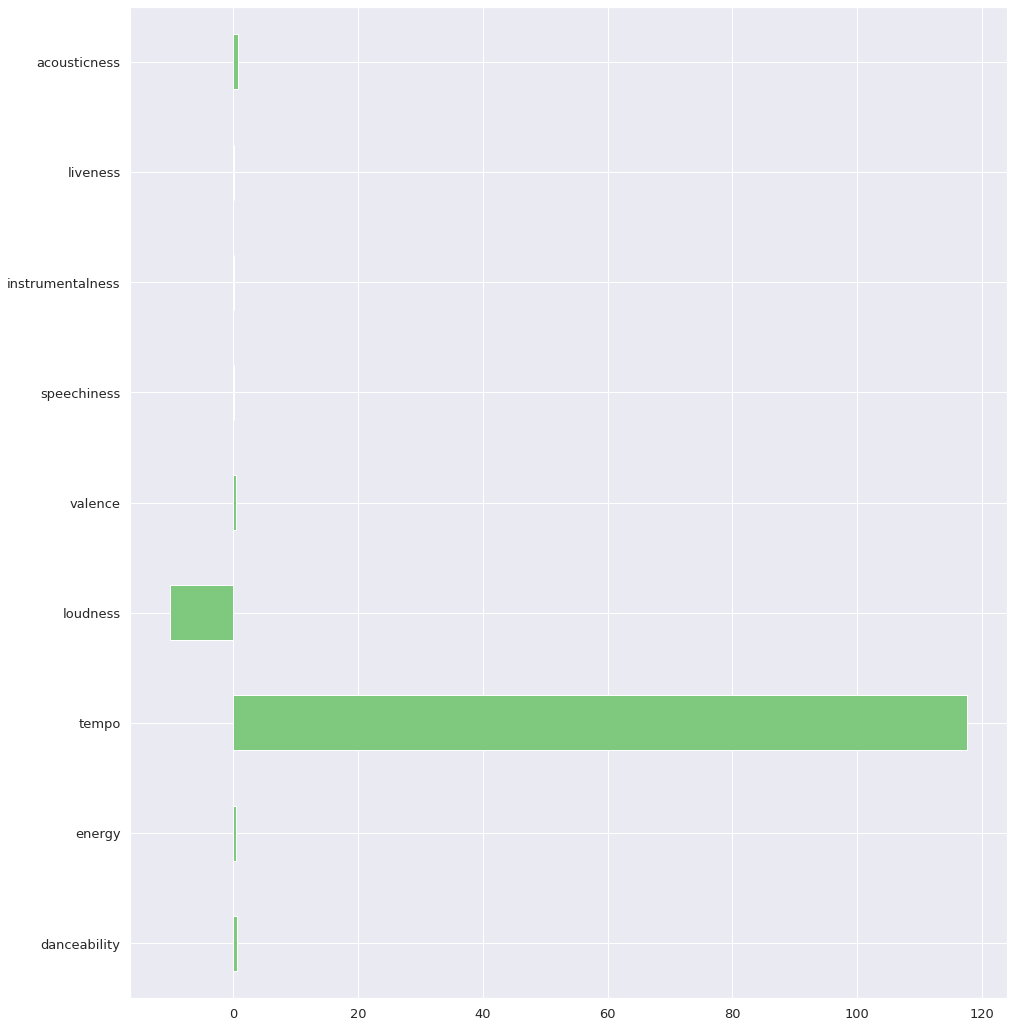

In [111]:
# visualiasikan rata rata seluruh feature 
df_joo.mean().plot.barh( colormap=plt.cm.Accent, fontsize=13)

In [112]:
hillu_mean = pd.DataFrame(df_hilu.mean(), columns= ['kimu'])
joo_mean = pd.DataFrame(df_joo.mean(), columns= ['joo'])


In [113]:
joo_kimu_mean = pd.concat([hillu_mean, joo_mean], axis=1)
joo_kimu_mean

,kimu,joo
danceability,0.634445,0.543763
energy,0.454026,0.384197
tempo,112.251595,117.658622
loudness,-8.875706,-10.152679
valence,0.439744,0.350188
speechiness,0.085894,0.036093
instrumentalness,0.034775,0.058155
liveness,0.162536,0.161461
acousticness,0.509955,0.661643


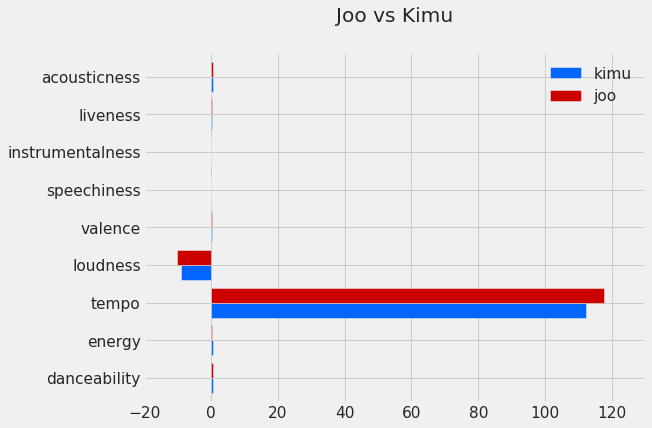

In [114]:

plt.style.use('fivethirtyeight')

joo_kimu_mean.plot.barh(color = ['#0066FF', '#CC0000'],  width = .8, rot = 0, figsize = (8,6))
plt.title('Joo vs Kimu', y = 1.07)
plt.xlim(-20,130) # because ratings start at 0 and end at 5
plt.legend(framealpha = 0, loc = 'upper right')
plt.show()

In [115]:
# tambah satu field (score) noramalize semua feature suapaya gampang di olah
df_joo['score'] = df_joo['danceability'] * 30 + df_joo['energy'] * 20 + df_joo['tempo'] * 20 + df_joo['loudness'] * 10 + df_joo['valence'] * 20
df_joo.describe()

,danceability,energy,tempo,loudness,valence,speechiness,instrumentalness,liveness,acousticness,score
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,0.543763,0.384197,117.658622,-10.152679,0.350188,0.036093,0.058155,0.161461,0.661643,2282.646249
std,0.137642,0.191817,29.235315,3.132749,0.193633,0.016018,0.160381,0.116935,0.291009,588.850250
min,0.136000,0.044100,51.533000,-20.175000,0.041100,0.023800,0.000000,0.053600,0.000169,917.680000
25%,0.438000,0.250000,95.990000,-11.975000,0.194000,0.028900,0.000006,0.102000,0.509000,1846.750000
50%,0.557000,0.334000,114.969000,-9.881000,0.321000,0.031900,0.000290,0.118000,0.783000,2225.370000
75%,0.645000,0.492000,134.895000,-7.883000,0.483000,0.036600,0.009400,0.161000,0.890000,2644.010000
max,0.821000,0.966000,207.963000,-3.070000,0.961000,0.190000,0.893000,0.684000,0.986000,4077.010000


In [116]:
df_hilu['score'] = df_hilu['danceability'] * 30 + df_hilu['energy'] * 20 + df_hilu['tempo'] * 20 + df_hilu['loudness'] * 10 + df_hilu['valence'] * 20
df_hilu.describe()

,danceability,energy,tempo,loudness,valence,speechiness,instrumentalness,liveness,acousticness,score
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.634445,0.454026,112.251595,-8.875706,0.439744,0.085894,0.034775,0.162536,0.509955,2193.183592
std,0.144127,0.172119,29.592892,3.015153,0.212793,0.081979,0.137866,0.116695,0.281855,598.658868
min,0.000000,0.062500,0.000000,-24.694000,0.000000,0.000000,0.000000,0.024300,0.000870,-130.500000
25%,0.539500,0.323000,89.990500,-10.421500,0.271500,0.037400,0.000000,0.101000,0.270500,1752.300000
50%,0.659000,0.459000,107.875000,-8.436000,0.396000,0.051800,0.000006,0.119000,0.538000,2090.790000
75%,0.739500,0.572500,130.175500,-6.838000,0.628000,0.097950,0.000566,0.177000,0.754000,2570.955000
max,0.944000,0.854000,199.691000,-3.754000,0.961000,0.469000,0.880000,0.948000,0.975000,3959.140000


In [117]:
df_joo_filtered = df_hilu[df_hilu['score'] > df_joo['score'].mean()].copy()
df_joo_filtered.head()

,track_name,danceability,energy,tempo,loudness,valence,speechiness,instrumentalness,liveness,acousticness,score
track_id,,,,,,,,,,,
1OxL1FWSEd7QmJoWLRP2NO,On My Mind (Jorja Smith X Preditah),0.710,0.662,130.037,-5.947,0.755,0.1750,0.000000,0.0723,0.420,2590.91
4mL59LVbKgOpEACxraGYdr,While We're Young,0.649,0.791,128.023,-6.013,0.811,0.1930,0.000002,0.1080,0.104,2551.84
2pg2TiYo9Rb8KeB5JjP7jS,Sativa,0.741,0.610,125.990,-7.340,0.720,0.0511,0.000000,0.5340,0.316,2495.23
7ivYWXqrPLs66YwakDuSim,like i need u,0.748,0.465,119.872,-8.163,0.412,0.0869,0.000000,0.2940,0.399,2355.79
5SlU0Yhi51jobhEiGE4xDv,2 soon,0.517,0.663,174.032,-6.688,0.146,0.0375,0.000000,0.3220,0.146,3445.45


## Create Playlist using Spotipy

In [118]:
scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=spotify_client_id, client_secret=spotify_client_secret, redirect_uri=redirect_uri)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [119]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [120]:
create_playlist(sp, username, 'mamimumemo', 'Simple Plyalist that made with python :) ')

In [121]:
fetch_playlists()

,id,name,#tracks
0,4WHHeVm8Yr5WTgZ0qAtzdi,mamimumemo,0
1,6rE4pkAcCzsrKFFaqTUfG7,mamimumemo,133
2,7AFQPqLpbDYkOr9bYAbHlJ,hilu kimu wulrd,299
3,7JnQZulXjxqJcTGBjRQcId,+2 nov :),249
4,5FLDyGcuJqAedwjPbhCNeA,My playlist #1,3


In [122]:
def enrich_playlist(playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 100])
        index += 100

In [123]:
enrich_playlist('6rE4pkAcCzsrKFFaqTUfG7', df_joo_filtered.index)

In [124]:
fetch_playlists()

,id,name,#tracks
0,4WHHeVm8Yr5WTgZ0qAtzdi,mamimumemo,0
1,6rE4pkAcCzsrKFFaqTUfG7,mamimumemo,254
2,7AFQPqLpbDYkOr9bYAbHlJ,hilu kimu wulrd,299
3,7JnQZulXjxqJcTGBjRQcId,+2 nov :),249
4,5FLDyGcuJqAedwjPbhCNeA,My playlist #1,3
